# Project 3


#
**Problem Statement**
- Is it clear what the goal of the project is?
- What type of model will be developed?
- How will success be evaluated?
- Is the scope of the project appropriate?
- Is it clear who cares about this or why this is important to investigate?
- Does the student consider the audience and the primary and secondary stakeholders?

## Problem Statment: 

## 1. Using PRAW, you'll collect posts from two subreddits of your choosing.

In [32]:
import praw
import pandas as pd
import nltk
import pandas as np
import unicodedata
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split 
from textblob import Word
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
from sklearn.manifold import TSNE


In [33]:
reddit = praw.Reddit(
    client_id='zus9cDU7x8IncmqOLReFYA',
    client_secret='3O1U8qnB3GGxPE4UtM3tpTq1qMuXfA',
    user_agent='Pro3',
    username='-__A__-',
    password=''
)

In [34]:
# Below is JUST an example of how you can use PRAW

# Choose your subreddit
subreddit_DataScience = reddit.subreddit('DataScience')
subreddit_wallstreetbets = reddit.subreddit('wallstreetbets')

# Adjust the limit as needed -- Note that this will grab the 25 most recent posts
posts_DS = subreddit_DataScience.new(limit=2525)
posts_wsb = subreddit_wallstreetbets.new(limit=2525)

In [35]:
data = []
for post in posts_DS:
    data.append([post.title, post.selftext, post.subreddit])

# Turn into a dataframe
datascience = pd.DataFrame(data, columns = ['title', 'self_text', 'subreddit'])
datascience.head()

,title,self_text,subreddit
0,Networking and seeking jobs,So my university occasionally invites people w...,datascience
1,Data Structures & Algorithms in Data Science,hi ppl. I'm wondering if it is useful to learn...,datascience
2,Which online course for learning about data sc...,"Hi, I am a mining engineer and I just realised...",datascience
3,Plotting and sorting engineering raw data cont...,"Hi,\n\nI often analyze many engineering data c...",datascience
4,Which city in the USA has the most Asian male ...,I mean which city has the highest rate,datascience


In [36]:
data_wsb = []
for post in posts_wsb:
    data_wsb.append([post.title, post.selftext, post.subreddit])

# Turn into a dataframe
wsb = pd.DataFrame(data_wsb, columns = ['title', 'self_text', 'subreddit'])
wsb.head()

,title,self_text,subreddit
0,Tesla Cybertruck faces 'enormous production an...,,wallstreetbets
1,Elon Musk loses $24 billion after Tesla stock ...,,wallstreetbets
2,Mom I'm rich,I never really gamble much but I saw bonds sur...,wallstreetbets
3,"Powell Says Fed ‘Proceeding Carefully,’ Leaves...",,wallstreetbets
4,Please post Tesla loss porn,I have nothing to nut to,wallstreetbets


In [37]:
df = pd.concat([datascience, wsb])


In [38]:
df.subreddit.value_counts()

datascience       859
wallstreetbets    733
Name: subreddit, dtype: int64

In [39]:
df.head()

,title,self_text,subreddit
0,Networking and seeking jobs,So my university occasionally invites people w...,datascience
1,Data Structures & Algorithms in Data Science,hi ppl. I'm wondering if it is useful to learn...,datascience
2,Which online course for learning about data sc...,"Hi, I am a mining engineer and I just realised...",datascience
3,Plotting and sorting engineering raw data cont...,"Hi,\n\nI often analyze many engineering data c...",datascience
4,Which city in the USA has the most Asian male ...,I mean which city has the highest rate,datascience


In [220]:
df.tail()

,subreddit,post,cleaned_post
1587,datascience,title: Title change question text: Is Changing...,: Title change question : Is Changing a job o...
1588,wallstreetbets,title: $CVNA Carvana YOLO text: This might fuc...,: $CVNA Carvana YOLO : This might fuck me over...
1589,wallstreetbets,title: Boa still offer 4% cash advance for 1 y...,: Boa still offer % cash advance for year sha...
1590,datascience,title: planning to study data science in colle...,": planning to study data science in college, s..."
1591,datascience,title: Meme Mondays text:,: Meme Mondays :


### 

### Shuffling the DataFrame 

In [40]:
df = df.sample(frac = 1)
df[:10]

,title,self_text,subreddit
370,Bit of guidance?,I've made some XgBoost models and found some g...,datascience
858,What tools can I use to make some interactive ...,&#x200B;\n\nhttps://preview.redd.it/b7cq72shjd...,datascience
265,The most sought-after Data Science skills,"I've analyzed 9,261 job openings' descriptions...",datascience
375,"Sunday, Oct 1st, is the last day to submit you...",Here is What We’re Looking For in Your Proposa...,datascience
786,Con artist company,My employer is conning Fortune 500 companies i...,datascience
488,Modern Time Series Forecasting With Python (Bo...,TLDR for those who don't want to read the whol...,datascience
465,TSLA PUTS ALL IN,I predicted SPY hitting 430 on Friday last wee...,wallstreetbets
54,Shared Public Contextual Database for RAG,"Hey Guys, \nIt seems RAG is really taking off...",datascience
480,Old Republic Actuarial Analyst Salary?,What is the salary for a first year full time ...,datascience
529,"Did academics prepare you for your role, or fo...",I browse through post often and general have l...,datascience


### Fearture engineering and pre-processing

Merging title and self_text

In [41]:
df['post'] = df.apply(lambda row: f"title: {row['title']} text: {row['self_text']}", axis=1)
df.head()

,title,self_text,subreddit,post
370,Bit of guidance?,I've made some XgBoost models and found some g...,datascience,title: Bit of guidance? text: I've made some X...
858,What tools can I use to make some interactive ...,&#x200B;\n\nhttps://preview.redd.it/b7cq72shjd...,datascience,title: What tools can I use to make some inter...
265,The most sought-after Data Science skills,"I've analyzed 9,261 job openings' descriptions...",datascience,title: The most sought-after Data Science skil...
375,"Sunday, Oct 1st, is the last day to submit you...",Here is What We’re Looking For in Your Proposa...,datascience,"title: Sunday, Oct 1st, is the last day to sub..."
786,Con artist company,My employer is conning Fortune 500 companies i...,datascience,title: Con artist company text: My employer is...


In [42]:
df.drop(['title','self_text'], axis=1, inplace=True)

In [43]:
df.head()

,subreddit,post
370,datascience,title: Bit of guidance? text: I've made some X...
858,datascience,title: What tools can I use to make some inter...
265,datascience,title: The most sought-after Data Science skil...
375,datascience,"title: Sunday, Oct 1st, is the last day to sub..."
786,datascience,title: Con artist company text: My employer is...


### Preprocessing
I making use of Regex to remove numbers and links from the post and creating a new column called cleaned post with processed text.

In [44]:
pattern = r'\b\d+\b|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
df['cleaned_post'] = df['post'].replace(pattern, '', regex=True)

# EDA
* Starting off with highest single word count.
* Highest bigrams count
* Highest trigram count

### We will use countvectorizer with ngram_range:
* ngram_range = (1,1) -> To do EDA on unigrams
* ngram_range = (2,2) -> To do EDA on bigrams
* ngram_range = (3,3) -> To do EDA on bigrams

In [45]:
#intitialize CountVectorizer 
vectorizer = CountVectorizer()

In [46]:
#fit 
wm = vectorizer.fit_transform(df['cleaned_post'])

In [47]:
wm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [48]:
df_vect_ex = pd.DataFrame(wm.toarray(), columns= vectorizer.get_feature_names_out(), index=df.index)

In [49]:
df_vect_ex

,06pm,0dte,0dtes,0s,0t,0th,1000s,100_000_000,100bps,100k,...,za,zero,zhang,zhuzh,zig,zillow,zone,zones,zoom,zoomer
370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
858,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
786,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df_vect_ex['target_subreddit'] = df['subreddit']

In [51]:
Count_w = df_vect_ex.drop('target_subreddit', axis=1).sum().sort_values(ascending = False)

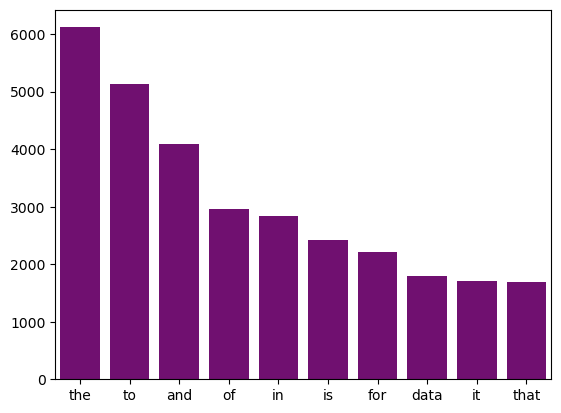

In [52]:
import seaborn as sns
sns.barplot(x=Count_w.index[:10], y = Count_w[:10], color='purple')
plt.show()

In [53]:
def gettopten(df):
    nv = CountVectorizer(stop_words='english', token_pattern= (r'\b(?!http\b|https\b|www\b|ftp\b)(?<!http)(?<!https)(?<!www)(?<!ftp)'
           r'\b[^\d\W]+\b(?!.[a-zA-Z0-9]+\b)'))
    nvv = nv.fit_transform(df['cleaned_post'])
    df_no = pd.DataFrame(nvv.toarray(), columns= nv.get_feature_names_out(), index= df.index)
    new_count = df_no.sum().sort_values(ascending=False)
    return sns.barplot(x=new_count.index[:10],y=new_count[:10], palette='colorblind') 


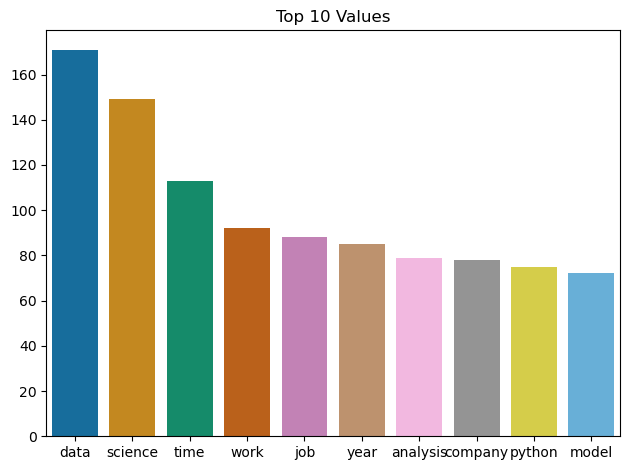

In [222]:
gettopten(df)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()


## Now we will check top 10 word counts in each subreddit

In [55]:
df[df['subreddit'] == 'datascience']

,subreddit,post,cleaned_post
370,datascience,title: Bit of guidance? text: I've made some X...,title: Bit of guidance? text: I've made some X...
858,datascience,title: What tools can I use to make some inter...,title: What tools can I use to make some inter...
265,datascience,title: The most sought-after Data Science skil...,title: The most sought-after Data Science skil...
375,datascience,"title: Sunday, Oct 1st, is the last day to sub...","title: Sunday, Oct 1st, is the last day to sub..."
786,datascience,title: Con artist company text: My employer is...,title: Con artist company text: My employer is...
...,...,...,...
621,datascience,title: Can LOR be sent through personal email ...,title: Can LOR be sent through personal email ...
366,datascience,title: What’s the point of learning Spark if y...,title: What’s the point of learning Spark if y...
418,datascience,title: Title change question text: Is Changing...,title: Title change question text: Is Changing...
724,datascience,title: planning to study data science in colle...,title: planning to study data science in colle...


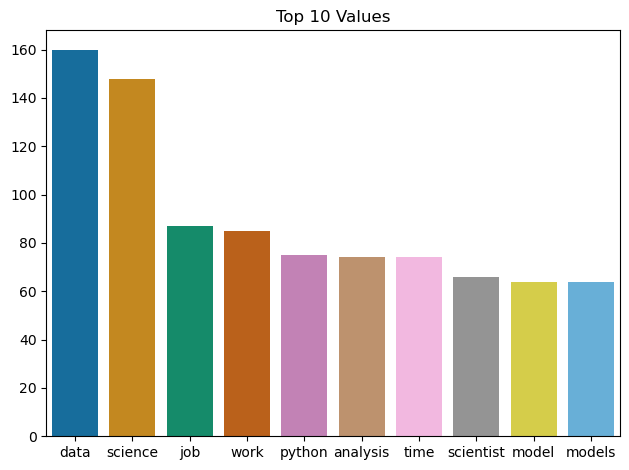

In [223]:
gettopten(df[df['subreddit'] == 'datascience'])
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

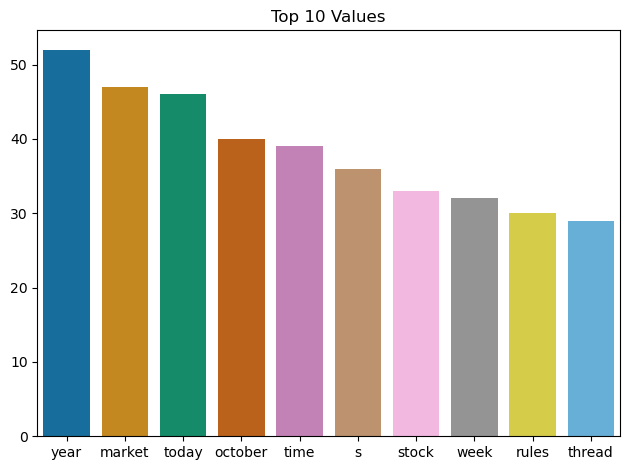

In [224]:
gettopten(df[df['subreddit'] == 'wallstreetbets'])
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

In [241]:
def gettop10(df,n,stop='english'):
    cvec = CountVectorizer(ngram_range=(n,n), stop_words= stop)

    nvv = cvec.fit_transform(df['cleaned_post'])
    df_no = pd.DataFrame(nvv.toarray(), columns= cvec.get_feature_names_out(), index= df.index)
    new_count = df_no.sum().sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    plt.tight_layout()
    return sns.barplot(x=new_count[:10],y=new_count.index[:10], palette='colorblind') 

## Top 10 highest occuring bigrams in the entire dataset

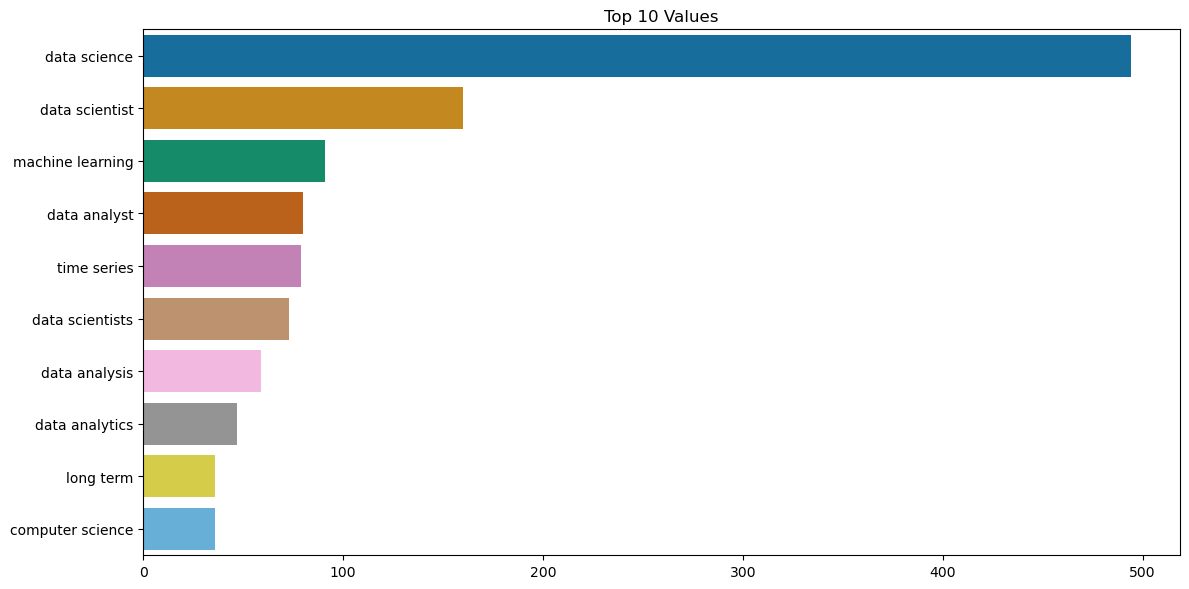

In [242]:
gettop10(df,2)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Discovery:
There seems to be a word that appears frequently called `x200b`. Upon further investigation, this is the unicode for **whitespace character**. We will need to modify our post and remove this chracter with help of regex.

In [60]:
df['cleaned_post'] = df['cleaned_post'].replace(r'x200B|text|title|\n|\'', '', regex=True)

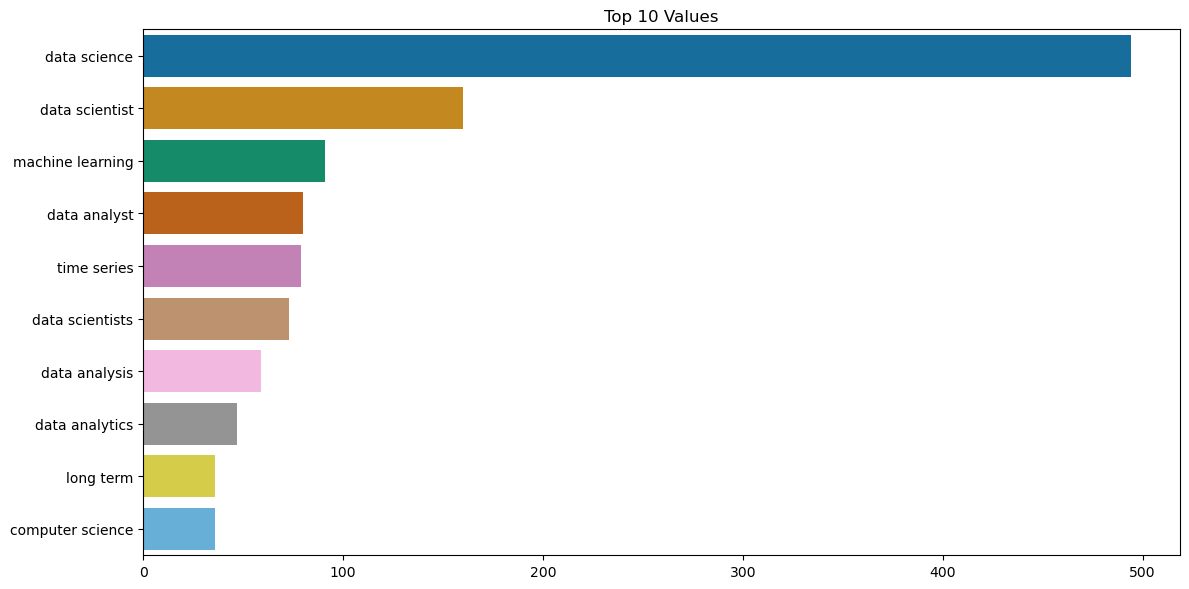

In [226]:
gettop10(df,2)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Top 10 occurring bigrams in the wallstreetbets

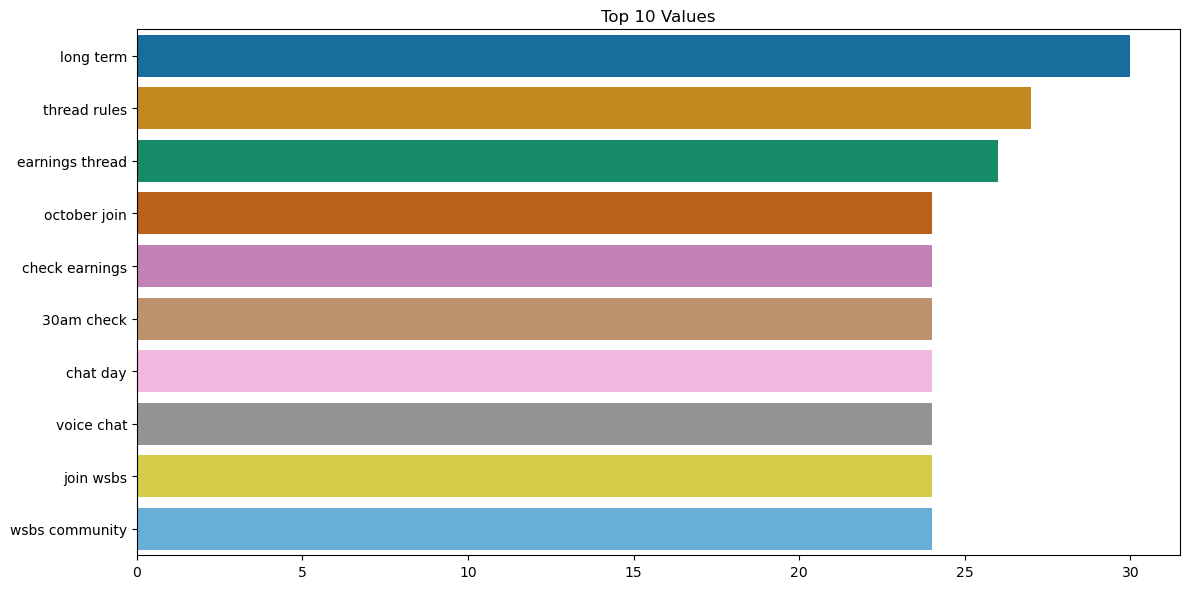

In [227]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],2)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Top 10 occurring bigrams in the datascience 

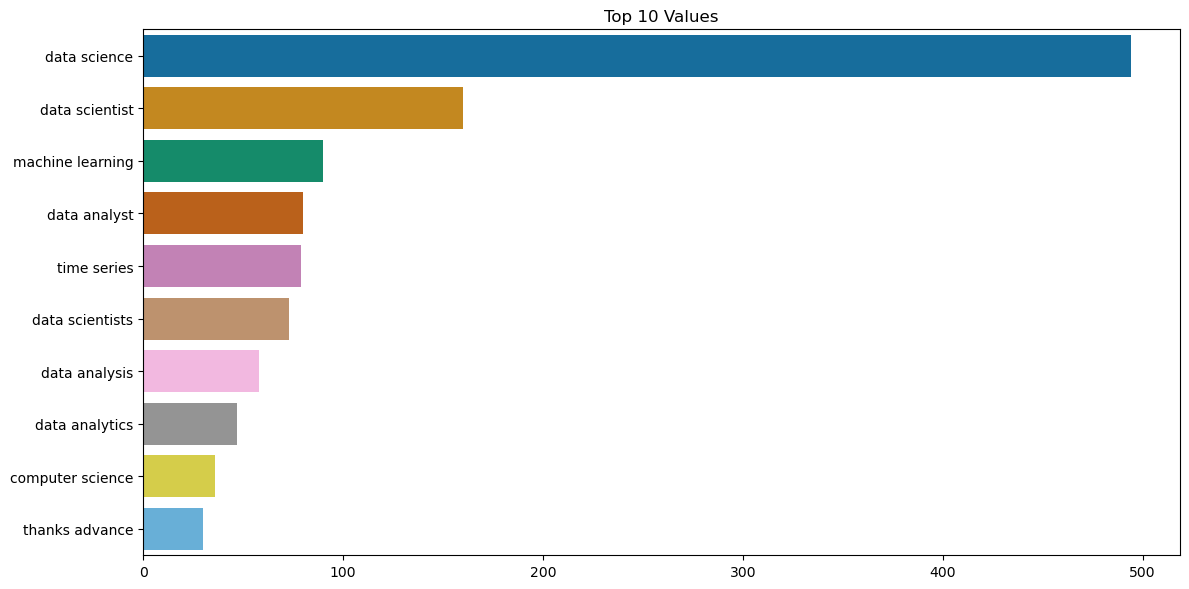

In [228]:
gettop10(df[df['subreddit'] == 'datascience'],2)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Top 10 occurring trigrams in the wallstreetbets

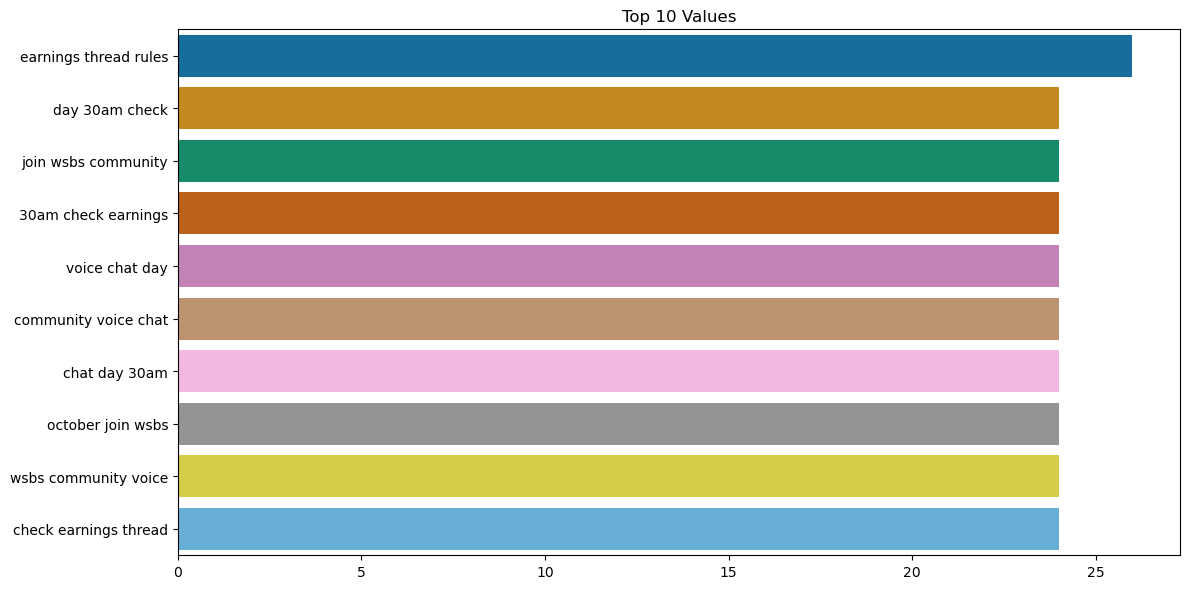

In [229]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Top 10 occurring trigrams in the datascience

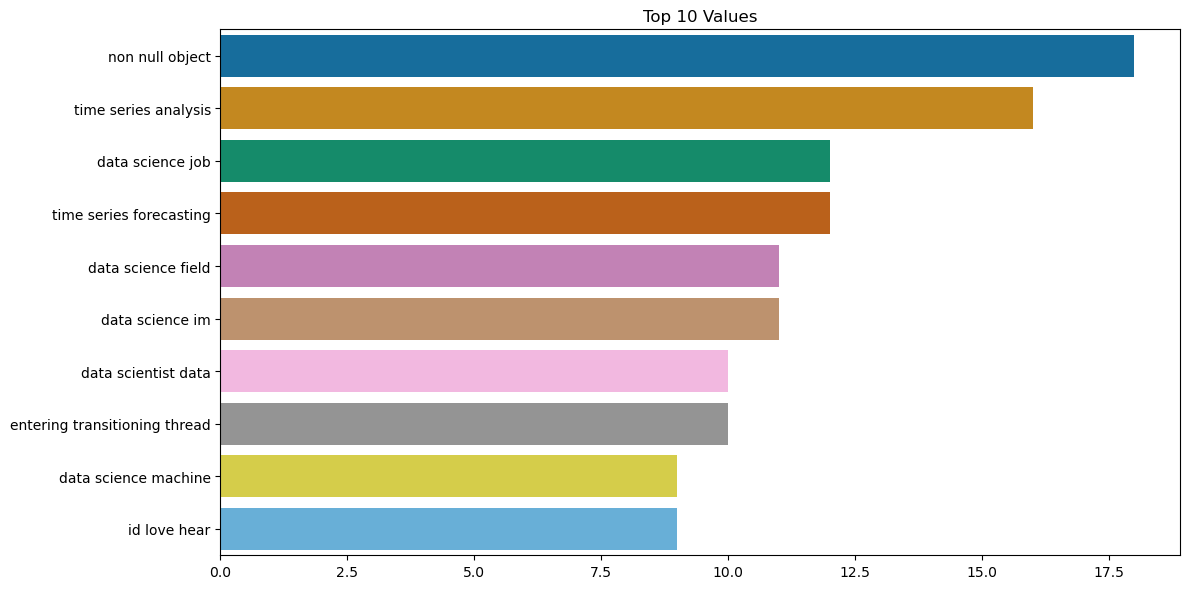

In [230]:
gettop10(df[df['subreddit'] == 'datascience'],3)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## Trigrams with stopwords

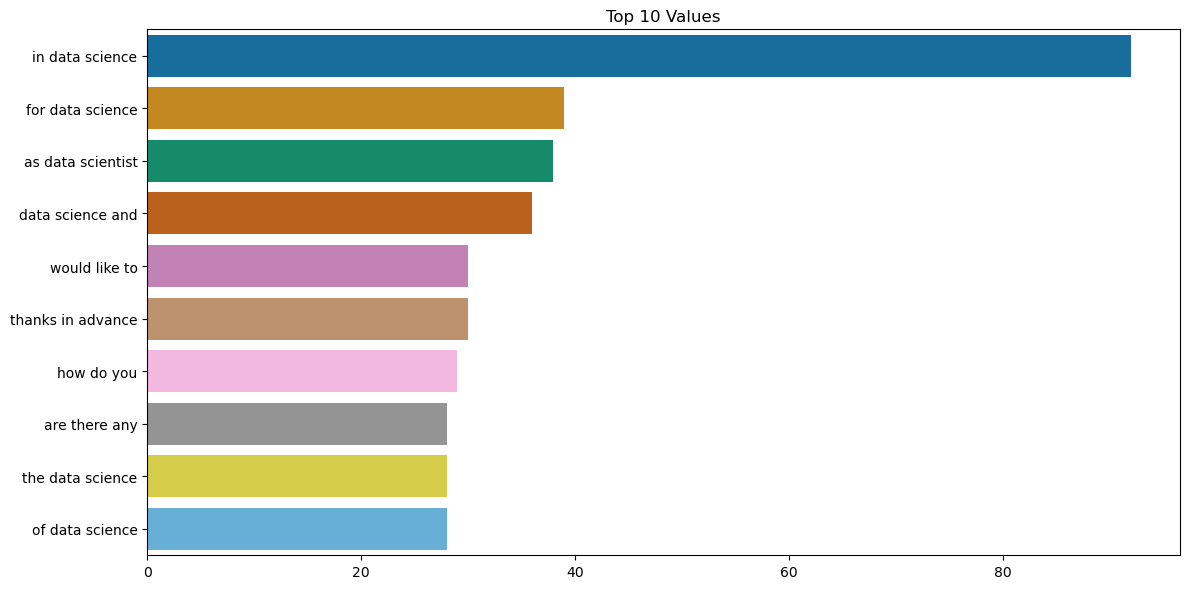

In [231]:
gettop10(df[df['subreddit'] == 'datascience'],3,stop=None)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

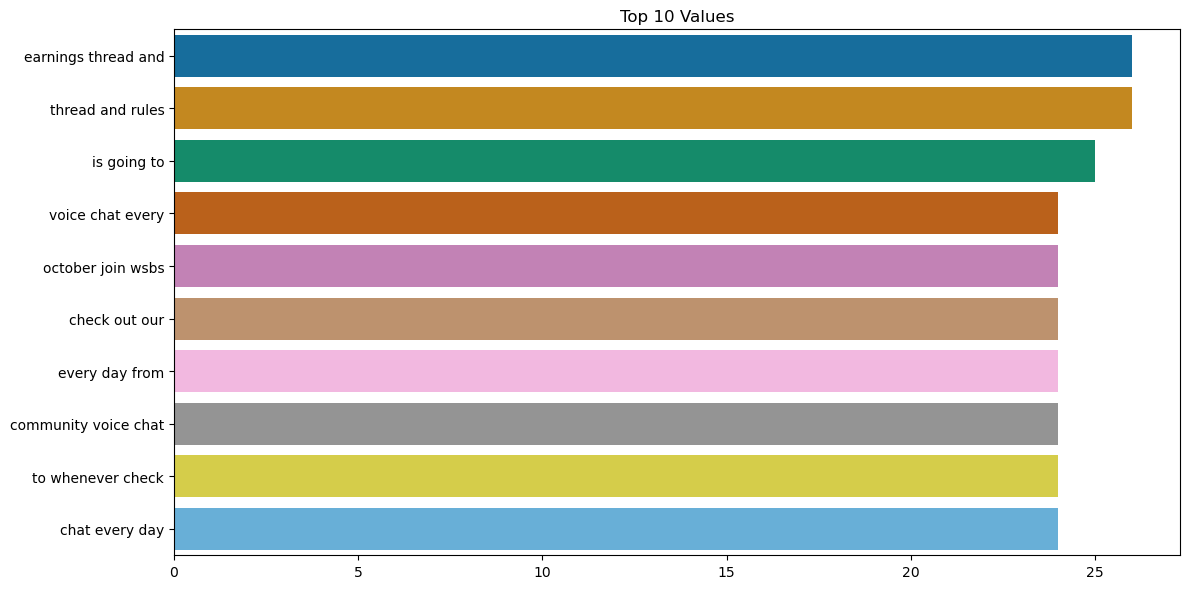

In [232]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3,stop=None)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## 4-gram with stopwords

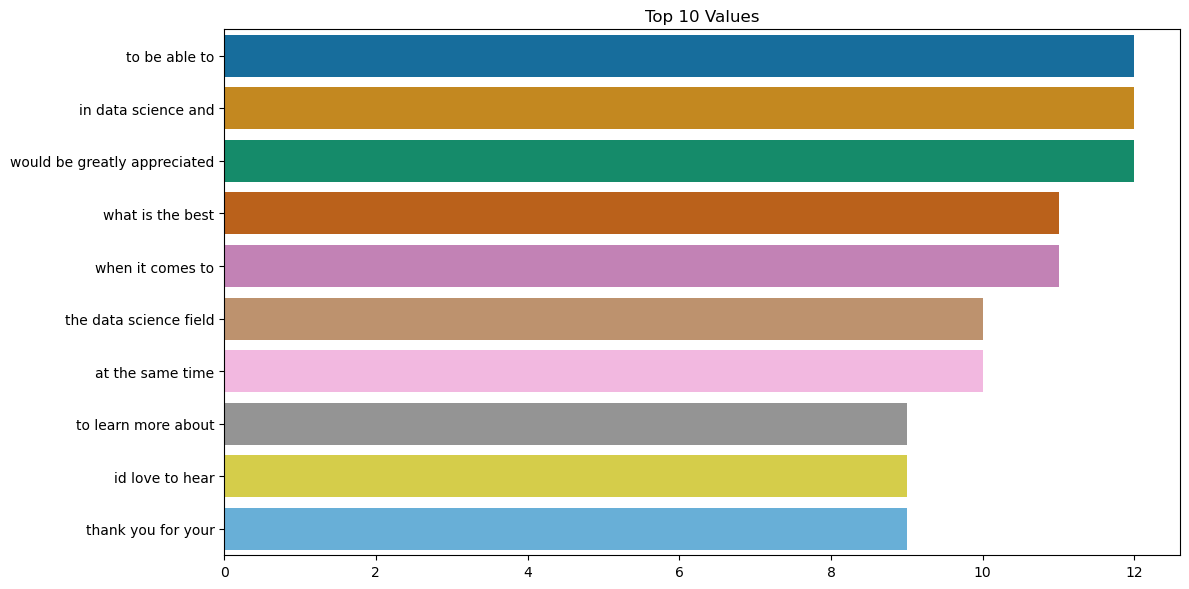

In [233]:
gettop10(df[df['subreddit'] == 'datascience'],4,stop=None)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

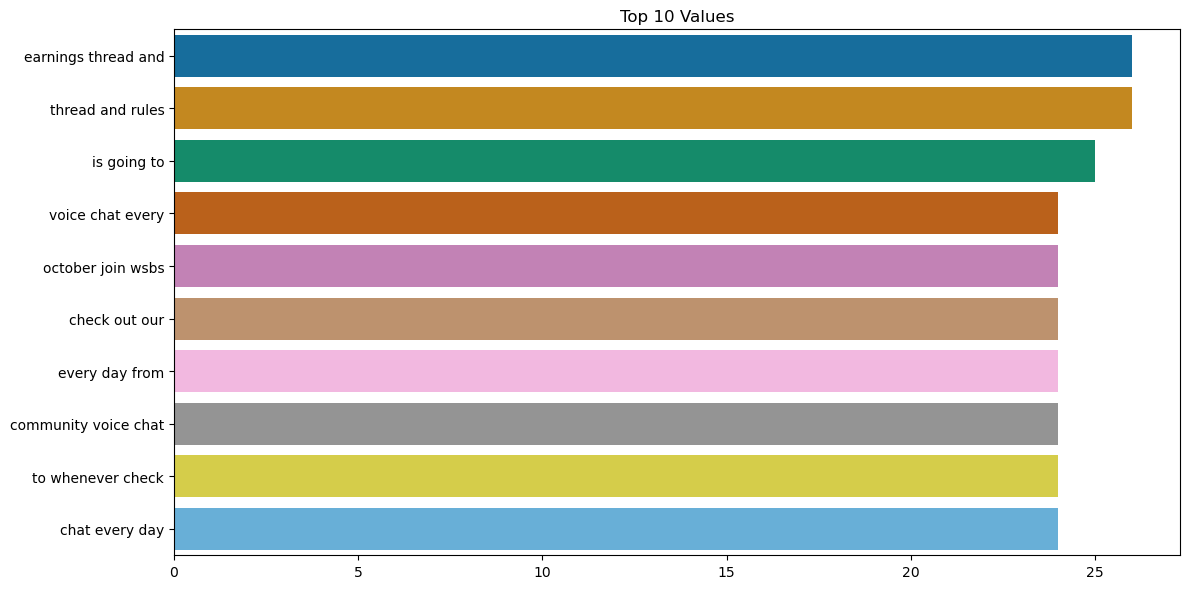

In [234]:
gettop10(df[df['subreddit'] == 'wallstreetbets'],3,stop=None)
plt.title('Top 10 Values')
plt.tight_layout()
plt.show()

## T-SNE Visulization

In [133]:
df.reset_index(drop=True, inplace=True)

In [191]:
color_palette = [ '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
#'#E69F00', '#56B4E9','#0072B2'

In [243]:

def tsne_viz(df, n, stop='english'):
   
    cvec = TfidfVectorizer(ngram_range=(n,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], 
                         c=pd.factorize(df['subreddit'])[0], cmap="viridis", s=60)
    
    legend1 = ax.legend(*scatter.legend_elements(), title="Subreddits")
    ax.add_artist(legend1)
    
    ax.set_title('3D t-SNE Visualization')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    
    plt.show()



c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



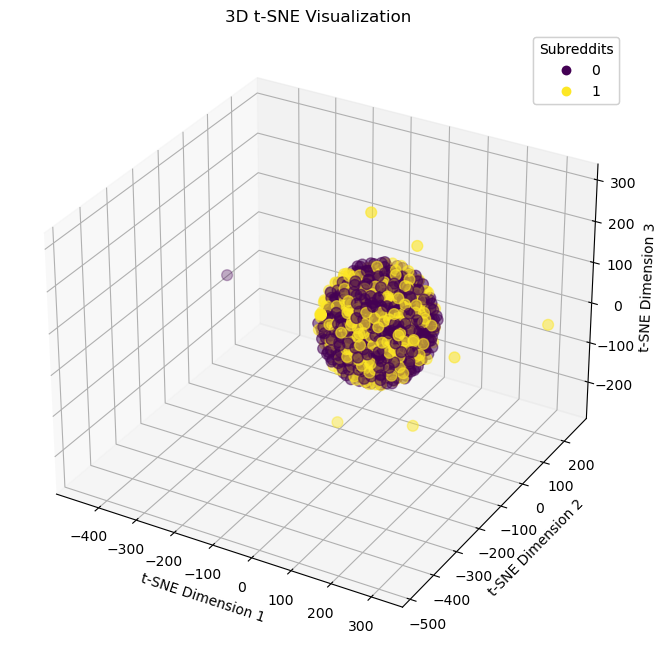

In [244]:
tsne_viz(df, 3, stop='english')

In [192]:

def tsne_vizinter(df, n, stop='english'):

    cvec = TfidfVectorizer(ngram_range=(n-1,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
       
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
   
    df_tsne = pd.DataFrame(tsne_results, columns=['dim1', 'dim2', 'dim3']).reset_index(drop=True)
    df_tsne['subreddit'] = df['subreddit'].reset_index(drop=True)
    
    fig = px.scatter_3d(df_tsne, x='dim1', y='dim2', z='dim3', color='subreddit',color_discrete_sequence=color_palette)
    fig.show()




In [193]:
tsne_vizinter(df, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



We can see that bigrams and trigrams gives a mixed cluster 

In [194]:

def tsne_viz_index(df, n, stop='english'):

    cvec = TfidfVectorizer(ngram_range=(n-1,n), stop_words=stop)
    vectorized_matrix = cvec.fit_transform(df['cleaned_post'])
    
    tsne = TSNE(n_components=3, random_state=42)
    tsne_results = tsne.fit_transform(vectorized_matrix.toarray())
    
    df_tsne = pd.DataFrame(tsne_results, columns=['dim1', 'dim2', 'dim3'])
    df_tsne['subreddit'] = df['subreddit'].reset_index(drop=True)
    df_tsne['index'] = df.index  # Add the index as a column

    fig = px.scatter_3d(df_tsne, x='dim1', y='dim2', z='dim3', color='subreddit', hover_data=['index'],color_discrete_sequence=color_palette)
    fig.show()



In [195]:
tsne_viz_index(df, 2, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



We see unigram and bigram features give a good cluster.

In [196]:
print(df.iloc[501]['cleaned_post']),  # Checking out the outlier post in the above visuallization 
print(df.iloc[501]['subreddit'])

:  : 
wallstreetbets


An outlier that only has a title and a : for text.

In [197]:
print(df.iloc[1148]['cleaned_post']),  # Checking out the outlier post in the above visuallization 
print(df.iloc[1148]['subreddit'])

: Alright geniuses; give me a home buying advice 😅 : Would you buy an apartment with current interest rates or wait for a few more months?I have 70k saved; no debt whatsoever except rent $1k; and other typical expenses. Shooting for an apartment top 200k in value.
wallstreetbets


This post is identified as an outlier by TSNE visulization correctly as it is talking about homw buying in the wallstreetbets subreddit.

In [198]:
print(df.iloc[59]['cleaned_post']),  # Checking out the outlier post in the above visuallization 
print(df.iloc[59]['subreddit'])

: What I wish I had known earlier in my career, particularly with disorganized companies :  Im quoting directly from a Reddit user named funbike. This is the rule you should abide by in organizations. I also made the same mistake when I joined a company, attempting to prove myself." After being a fool in my early career trying too hard to impress, this is how I handle this kind of thing these days:* Document EVERYTHING. Follow-up verbal conversations with summary email. When things go south, Ill be able to prove I warned them.* Give *realistic* estimates on how long things will take. Whatever I say is usually twice how long I actually think it will take, because things never go like you think.* Make it clear that that longer-term estimates will be less accurate the farther out they are, because software is notoriously difficult to estimate.* Tell them to their face that we *will not* make the unrealistic dates theyve set, and to prevent in future to always consult first.* I will *not* 

Another example of an outlier.

In [199]:
tsne_viz_index(df, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Trigrams and bigrams fetures give a mix cluster.

In [200]:
print(df.iloc[376]['cleaned_post']),  # Checking out the outlier post in the above visuallization 
print(df.iloc[376]['subreddit'])

: What Would It Take to Balance the Budget? : 
wallstreetbets


This post is quite ambugious.


Further cleaning 

In [201]:
import re # Source Chat GPT

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove Emojis
    emoji_pattern = re.compile(
        u"([\U00002600-\U000027BF])|"  # Misc symbols
        u"([\U0001F600-\U0001F64F])|"  # Emoticons
        u"([\U0001F300-\U0001F5FF])|"  # Symbols & pictographs
        u"([\U0001F680-\U0001F6FF])|"  # Transport & map symbols
        u"([\U0001F700-\U0001F77F])|"  # Alchemical symbols
        u"([\U0001F780-\U0001F7FF])|"  # Geometric shapes ext
        u"([\U0001F800-\U0001F8FF])|"  # Supplemental arrows C
        u"([\U0001F900-\U0001F9FF])|"  # Supplemental symbols
        u"([\U0001FA00-\U0001FA6F])|"  # Chess symbols
        u"([\U0001FA70-\U0001FAFF])"   # Symbols and pictographs ext A
        , re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove placeholder text
    text = re.sub(r'Daily Discussion Thread for [A-Za-z\s]+,', '', text)
    
    return text


In [202]:
df2 = df.copy()

In [203]:
df2['cleaned_post'] = df2['cleaned_post'].apply(clean_text)

In [204]:
tsne_viz_index(df2, 3, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Even after further cleaning bigrams and trigrams fetures still give a mix cluster this implies that bigrams and trigrams fetures are not a good choise for modeling purposes. 

In [159]:
print(df2.iloc[1162]['cleaned_post']) # Checking out the outlier post in the above visuallization 
print(df2.iloc[1162]['subreddit'])

: Rise :
wallstreetbets


This person just posted an emoji which TSNE vizulization correctly classifies as an extrem outlier.

In [160]:
print(df2.iloc[193]['cleaned_post']) # Checking out the outlier post in the above visuallization 
print(df2.iloc[193]['subreddit'])

: Buckle Up :
wallstreetbets


This is the same person.

In [205]:
tsne_viz_index(df2, 4, stop='english')

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\muham\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Trigrams and 4-grams give a mixed cluster.

__The TSNE visualization shows that unigram and bigram features gives us the best clusters.__

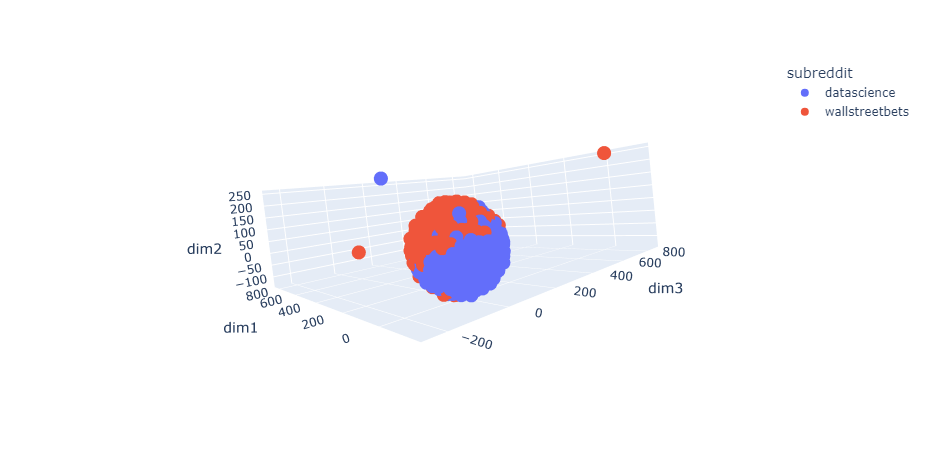


## Modeling

In [206]:
X= df2['cleaned_post']
y=df2['subreddit'].reset_index(drop=True)
y= y.apply(lambda x: x.display_name)


In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [219]:

pgrid = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1, 1), (1, 2), (2,2)],
    'logit__penalty': ['l1','l2'],
    'logit__C': [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50],
    'logit__max_iter': [1000],
    'logit__solver': ['liblinear']


}
  

In [215]:

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logit', LogisticRegression())
   ])


In [216]:
gs_tvec = GridSearchCV(pipe, pgrid, cv=10, n_jobs=6)


In [217]:
%%time
gs_tvec.fit(X_train, y_train)

c:\Users\muham\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


2160 fits failed out of a total of 8640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\muham\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\muham\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\muham\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.pe

Wall time: 5min 40s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logit', LogisticRegression())]),
             n_jobs=6,
             param_grid={'logit__C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                      0.1, 0.5, 1, 5, 10, 50],
                         'logit__max_iter': [1000],
                         'logit__penalty': ['l1', 'l2'],
                         'logit__solver': ['lbfgs', 'liblinear'],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [218]:
gs_tvec.score(X_test, y_test)

0.9723618090452262